In [ ]:
## Version: V1
## Author: Tore Bleckwehl
## August 2023

In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adata_vis = sc.read_h5ad("Visium_Slides_Human_Atherosclerosis.h5ad")

In [3]:
#Select a specific slide for analysis
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Initially testing of distance assignment

/Users/tbleckwehl/Library/Python/3.9/lib/python/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


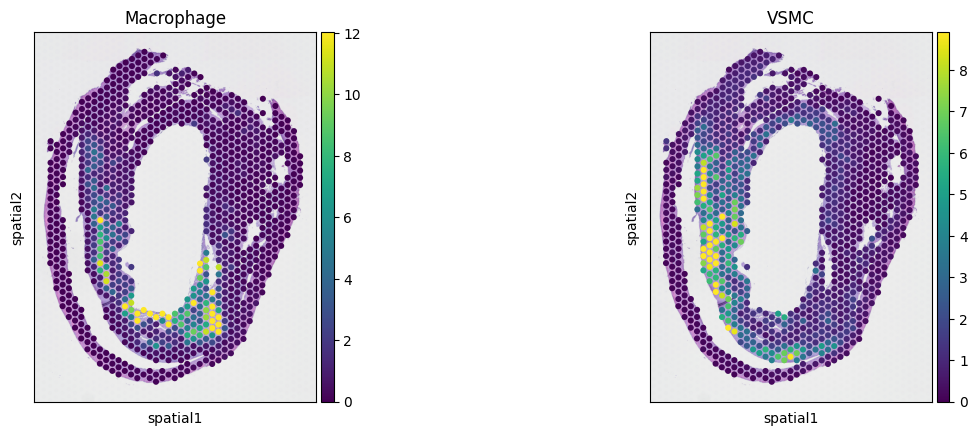

In [ ]:
#Visualization of the deconvoluted cell types
slide = select_slide(adata_vis, 'FW104860')
sc.pl.spatial(slide, cmap='viridis',
                  color=['Macrophage', 'VSMC'],
                  ncols=3, size=1.3,
                  img_key='hires',
                  vmin=0, vmax='p98'
                 )

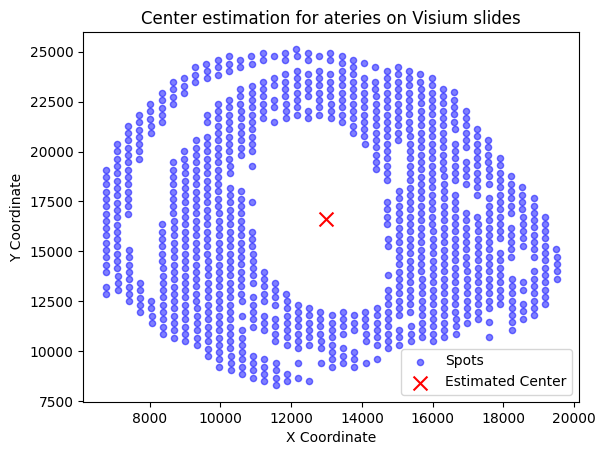

In [5]:
#Estimate the center within the atery (only for code evaluation)
spatial_coordinates = slide.obsm["spatial"]

# Calculate the center of the spatial coordinates
x_center = np.mean(spatial_coordinates[:, 0])
y_center = np.mean(spatial_coordinates[:, 1])


# Create a scatter plot of the original spatial coordinates
plt.scatter(spatial_coordinates[:, 0], spatial_coordinates[:, 1], s=20, c='b', alpha=0.5, label='Spots')

# Plot the estimated center point as a red cross
plt.scatter(x_center, y_center, marker='x', s=100, c='r', label='Estimated Center')

# Add labels, title, and legend
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Center estimation for ateries on Visium slides')
plt.legend()

# Show the plot
plt.show()


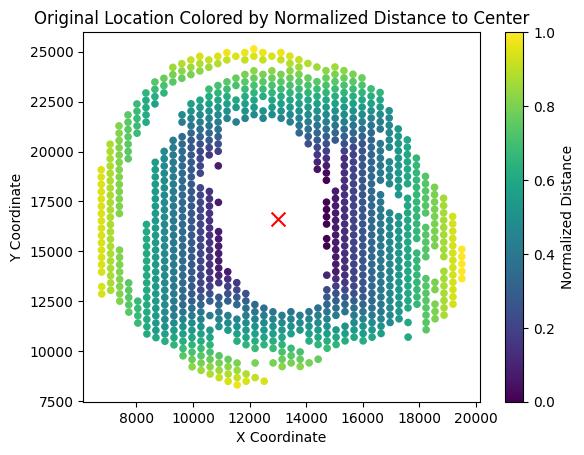

In [6]:
#Estimate the center within the atery and the distance from it (only for code evaluation)
spatial_coordinates = slide.obsm["spatial"]

# Calculate the center of the spatial coordinates
x_center = np.mean(spatial_coordinates[:, 0])
y_center = np.mean(spatial_coordinates[:, 1])

# Calculate the distance of each spot to the center
distances = np.sqrt((spatial_coordinates[:, 0] - x_center)**2 + (spatial_coordinates[:, 1] - y_center)**2)

# Find the minimum and maximum distances in both x and y directions
min_distance_x = np.min(np.abs(spatial_coordinates[:, 0] - x_center))
max_distance_x = np.max(np.abs(spatial_coordinates[:, 0] - x_center))

min_distance_y = np.min(np.abs(spatial_coordinates[:, 1] - y_center))
max_distance_y = np.max(np.abs(spatial_coordinates[:, 1] - y_center))

# Normalize the distances in each direction to the range [0, 1]
normalized_distances_x = (np.abs(spatial_coordinates[:, 0] - x_center) - min_distance_x) / (max_distance_x - min_distance_x)
normalized_distances_y = (np.abs(spatial_coordinates[:, 1] - y_center) - min_distance_y) / (max_distance_y - min_distance_y)

# Calculate the combined normalized distance
normalized_distances = np.maximum(normalized_distances_x, normalized_distances_y)

# Plot the original spatial coordinates colored by the normalized distance
plt.scatter(spatial_coordinates[:, 0], spatial_coordinates[:, 1], c=normalized_distances, cmap='viridis', s=20)

# Plot the estimated center point as a red cross
plt.scatter(x_center, y_center, marker='x', s=100, c='r')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Original Location Colored by Normalized Distance to Center')

# Show the colorbar
plt.colorbar(label='Normalized Distance')

# Show the plot
plt.show()


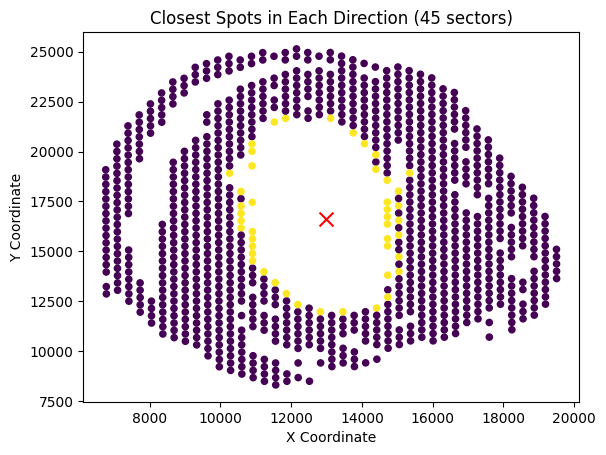

In [7]:
#Estimate the center within the atery and the spots with the minimal distance from it (only for code evaluation)
spatial_coordinates = slide.obsm["spatial"]

# Calculate the center of the spatial coordinates
x_center = np.mean(spatial_coordinates[:, 0])
y_center = np.mean(spatial_coordinates[:, 1])

# Calculate the angle (θ) for each spot relative to the center
relative_x = spatial_coordinates[:, 0] - x_center
relative_y = spatial_coordinates[:, 1] - y_center
angles_radians = np.arctan2(relative_y, relative_x)

# Convert angles to degrees and shift the range from [-180, 180] to [0, 360]
angles_degrees = np.degrees(angles_radians)
angles_degrees[angles_degrees < 0] += 360

# Find the closest spot in each of the 12 sectors
num_sectors = 45
sector_size = 360 / num_sectors

# Create an array to store the color for each spot
colors = np.zeros(len(spatial_coordinates))

for i in range(num_sectors):
    sector_start = i * sector_size
    sector_end = (i + 1) * sector_size
    
    # Find the indices of spots within the current sector
    sector_indices = np.where((angles_degrees >= sector_start) & (angles_degrees < sector_end))[0]
    
    # Find the index of the closest spot within the current sector
    idx_closest = sector_indices[np.argmin(distances[sector_indices])]
    
    # Assign color value 1 to the closest spot in the current sector
    colors[idx_closest] = 1

# Plot the original spatial coordinates colored by the closest spots
plt.scatter(spatial_coordinates[:, 0], spatial_coordinates[:, 1], c=colors, cmap='viridis', s=20)

# Plot the estimated center point as a red cross
plt.scatter(x_center, y_center, marker='x', s=100, c='r')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Closest Spots in Each Direction (45 sectors)')

# Show the plot
plt.show()


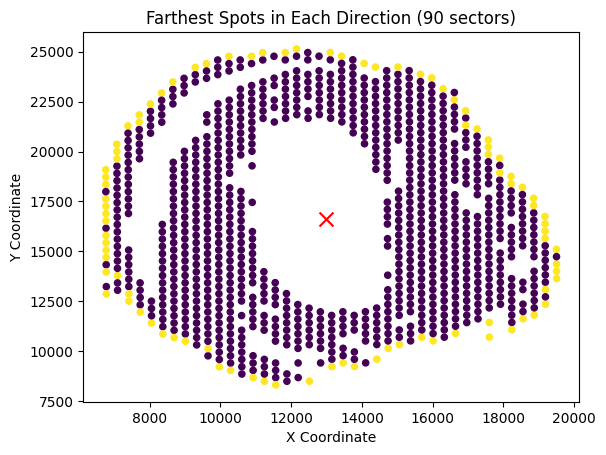

In [8]:
#Estimate the center within the atery and the spots with the max distance from it (only for code evaluation)
spatial_coordinates = slide.obsm["spatial"]

# Calculate the center of the spatial coordinates
x_center = np.mean(spatial_coordinates[:, 0])
y_center = np.mean(spatial_coordinates[:, 1])

# Calculate the angle (θ) for each spot relative to the center
relative_x = spatial_coordinates[:, 0] - x_center
relative_y = spatial_coordinates[:, 1] - y_center
angles_radians = np.arctan2(relative_y, relative_x)

# Convert angles to degrees and shift the range from [-180, 180] to [0, 360]
angles_degrees = np.degrees(angles_radians)
angles_degrees[angles_degrees < 0] += 360

# Find the most outer points in each of the 12 sectors
num_sectors = 90
sector_size = 360 / num_sectors

# Create an array to store the color for each spot
colors = np.zeros(len(spatial_coordinates))

for i in range(num_sectors):
    sector_start = i * sector_size
    sector_end = (i + 1) * sector_size
    
    # Find the indices of spots within the current sector
    sector_indices = np.where((angles_degrees >= sector_start) & (angles_degrees < sector_end))[0]
    
    # Find the index of the farthest spot within the current sector
    idx_farthest = sector_indices[np.argmax(distances[sector_indices])]
    
    # Assign color value 1 to the farthest spot in the current sector
    colors[idx_farthest] = 1

# Plot the original spatial coordinates colored by the farthest spots
plt.scatter(spatial_coordinates[:, 0], spatial_coordinates[:, 1], c=colors, cmap='viridis', s=20)

# Plot the estimated center point as a red cross
plt.scatter(x_center, y_center, marker='x', s=100, c='r')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Farthest Spots in Each Direction (90 sectors)')

# Show the plot
plt.show()


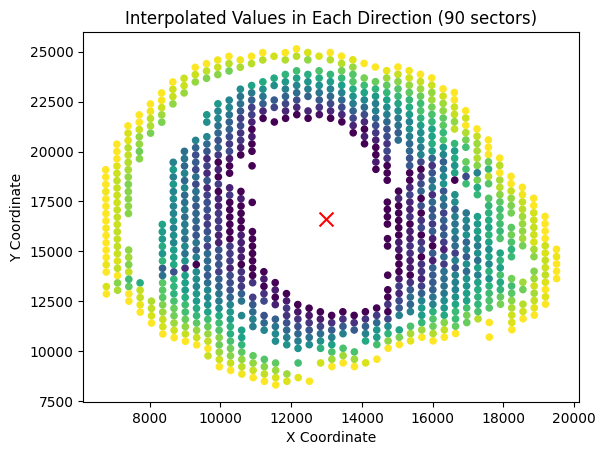

In [9]:
#Combine the approaches from above (only for code evaluation)
spatial_coordinates = slide.obsm["spatial"]

# Calculate the center of the spatial coordinates
x_center = np.mean(spatial_coordinates[:, 0])
y_center = np.mean(spatial_coordinates[:, 1])

# Calculate the angle (θ) for each spot relative to the center
relative_x = spatial_coordinates[:, 0] - x_center
relative_y = spatial_coordinates[:, 1] - y_center
angles_radians = np.arctan2(relative_y, relative_x)

# Convert angles to degrees and shift the range from [-180, 180] to [0, 360]
angles_degrees = np.degrees(angles_radians)
angles_degrees[angles_degrees < 0] += 360

# Find the indices of the closest and farthest spots in each of the 12 sectors
num_sectors = 90
sector_size = 360 / num_sectors

# Create an array to store the color for each spot
colors = np.zeros(len(spatial_coordinates))

for i in range(num_sectors):
    sector_start = i * sector_size
    sector_end = (i + 1) * sector_size
    
    # Find the indices of spots within the current sector
    sector_indices = np.where((angles_degrees >= sector_start) & (angles_degrees < sector_end))[0]
    
    # Find the index of the closest spot within the current sector
    idx_closest = sector_indices[np.argmin(distances[sector_indices])]
    
    # Find the index of the farthest spot within the current sector
    idx_farthest = sector_indices[np.argmax(distances[sector_indices])]
    
    # Calculate the distances to the closest and farthest spots
    dist_closest = distances[idx_closest]
    dist_farthest = distances[idx_farthest]
    
    # Calculate the interpolation values for the current sector
    values = (distances[sector_indices] - dist_closest) / (dist_farthest - dist_closest)
    
    # Assign the interpolation values to the corresponding spots
    colors[sector_indices] = values

# Plot the original spatial coordinates colored by the interpolation values
plt.scatter(spatial_coordinates[:, 0], spatial_coordinates[:, 1], c=colors, cmap='viridis', s=20)

# Plot the estimated center point as a red cross
plt.scatter(x_center, y_center, marker='x', s=100, c='r')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Interpolated Values in Each Direction (90 sectors)')

# Show the plot
plt.show()


## Functions to define subsamples

In [10]:
def assign_subsample_horizontal(adata, x_split=None, y_split_lower=None, y_split_higher=None):
    """
    Assigns subsample numbers to spots in an AnnData object based on x and y spatial coordinates splits.

    Parameters:
        adata (anndata.AnnData): An AnnData object containing the spatial coordinates.
        x_split (float or None): The value to split the x spatial coordinates into two subsamples. If None, no x split is applied.
        y_split_lower (float or None): The value to split y spatial coordinates when x spatial coordinate is lower than x_split. If None, no lower y split is applied.
        y_split_higher (float or None): The value to split y spatial coordinates when x spatial coordinate is higher than or equal to x_split. If None, no higher y split is applied.
    
    Returns:
        None (subsample assignment will be stored in adata.obs['subsample']).
    """
    # Usually the coordinates are stored in adata.obsm["spatial"]
    coordinates = adata.obsm["spatial"]

    # Create a new column to store the subsample assignment of each spot
    adata.obs['subsample'] = np.nan

    # Find the spot IDs from the AnnData object
    spot_ids = adata.obs.index

    if x_split is None:
        # If x_split is None, all spots belong to the same subsample
        adata.obs['subsample'] = "All"
        return

    if y_split_lower is None and y_split_higher is None:
        # If both y_split_lower and y_split_higher are None, all spots with x spatial coordinate lower than x_split
        # belong to one subsample, and all spots with x spatial coordinate higher than or equal to x_split belong to another subsample.
        subsample1_indices = np.where(coordinates[:, 0] < x_split)[0]
        subsample2_indices = np.where(coordinates[:, 0] >= x_split)[0]

        subsample1_spot_ids = spot_ids[subsample1_indices]
        subsample2_spot_ids = spot_ids[subsample2_indices]

        adata.obs.loc[subsample1_spot_ids, 'subsample'] = "A"
        adata.obs.loc[subsample2_spot_ids, 'subsample'] = "B"
        return

    # Assign spots to subsample 1 (x spatial coordinate lower than x_split and y spatial coordinate lower than y_split_lower)
    if y_split_lower is not None:
        subsample1_indices = np.where((coordinates[:, 0] < x_split) & (coordinates[:, 1] < y_split_lower))[0]
        subsample1_spot_ids = spot_ids[subsample1_indices]
        adata.obs.loc[subsample1_spot_ids, 'subsample'] = "A"

    # Assign spots to subsample 2 (x spatial coordinate higher than or equal to x_split and y spatial coordinate lower than y_split_higher)
    if y_split_higher is not None:
        subsample2_indices = np.where((coordinates[:, 0] >= x_split) & (coordinates[:, 1] < y_split_higher))[0]
        subsample2_spot_ids = spot_ids[subsample2_indices]
        adata.obs.loc[subsample2_spot_ids, 'subsample'] = "B"

    # Assign spots to subsample 3 (x spatial coordinate lower than x_split and y spatial coordinate higher than or equal to y_split_lower)
    if y_split_lower is not None:
        subsample3_indices = np.where((coordinates[:, 0] < x_split) & (coordinates[:, 1] >= y_split_lower))[0]
        subsample3_spot_ids = spot_ids[subsample3_indices]
        adata.obs.loc[subsample3_spot_ids, 'subsample'] = "C"

    # Assign spots to subsample 4 (x spatial coordinate higher than or equal to x_split and y spatial coordinate higher than or equal to y_split_higher)
    if y_split_higher is not None:
        subsample4_indices = np.where((coordinates[:, 0] >= x_split) & (coordinates[:, 1] >= y_split_higher))[0]
        subsample4_spot_ids = spot_ids[subsample4_indices]
        adata.obs.loc[subsample4_spot_ids, 'subsample'] = "D"

In [11]:
def assign_subsample_diagonal(adata, x_split=None, y_split=None):
    """
    Assigns subsample letters to spots in an AnnData object based on a diagonal line division.

    Parameters:
        adata (anndata.AnnData): An AnnData object containing the spatial coordinates.
        x_split (float or None): The x-coordinate value to determine the diagonal line equation. If None, no diagonal line division is applied.
        y_split (float or None): The y-coordinate value to determine the diagonal line equation. If None, no diagonal line division is applied.

    Returns:
        None (subsample assignment will be stored in adata.obs['subsample']).
    """
    # Coordinates are stored in adata.obsm["spatial"]
    coordinates = adata.obsm["spatial"]

    # Find the spot IDs from the AnnData object
    spot_ids = adata.obs.index

    if "subsample" not in adata.obs:
        # Create a new column to store the subsample assignment of each spot
        adata.obs['subsample'] = np.nan

    if x_split is None or y_split is None:
        # If either x_split or y_split is None, all spots belong to the same subsample
        adata.obs['subsample'] = "A"
        return

    # Calculate the slope and intercept of the diagonal line equation
    slope = y_split / x_split
    intercept = y_split

    # Assign spots based on their positions relative to the diagonal line
    for i in range(len(coordinates)):
        x = coordinates[i, 0]
        y = coordinates[i, 1]

        if y <= slope * x + intercept:
            # Spot is below or on the diagonal line
            adata.obs.at[spot_ids[i], 'subsample'] = "A"
        else:
            # Spot is above the diagonal line
            adata.obs.at[spot_ids[i], 'subsample'] = "B"

In [12]:
#Define the subsamples for each slide with the individual settings
adata_vis.obs["subsample"] = adata_vis.obs["sample"] 
adata_vis.obs["subsample"] = adata_vis.obs["subsample"].astype("object")


# Update the subsample information for each slide
slides = ['FW106005_v2', 'FW106006', 'FW106008', 'FW106010', 'FW106012', 'FW106014', 'FW106016', 'FW106018', 'FW106022']

for slide_name in slides:
    slide = select_slide(adata_vis, slide_name)

    if slide_name == 'FW106006':
        assign_subsample_horizontal(slide, x_split=15000, y_split_lower=20000, y_split_higher=0)
    elif slide_name == 'FW106008':
        assign_subsample_diagonal(slide, x_split=800, y_split=1100)
    elif slide_name == 'FW106010':
        assign_subsample_horizontal(slide, x_split=17000, y_split_lower=15000, y_split_higher=10000)
    elif slide_name == 'FW106012':
        assign_subsample_horizontal(slide, x_split=14000, y_split_lower=15000, y_split_higher=0)
    elif slide_name == 'FW106014':
        assign_subsample_horizontal(slide, x_split=19000, y_split_lower=16000, y_split_higher=17000)
    elif slide_name == 'FW106016':
        assign_subsample_horizontal(slide, x_split=15000)
    elif slide_name == 'FW106018':
        assign_subsample_horizontal(slide, x_split=14000, y_split_lower=16000, y_split_higher=14000)
    elif slide_name == 'FW106022':
        slide.obs["subsample"] = "A"
    elif slide_name == 'FW106005_v2':
        slide.obs["subsample"] = "A"

    adata_vis.obs.loc[slide.obs.index, "subsample"] = slide.obs.subsample


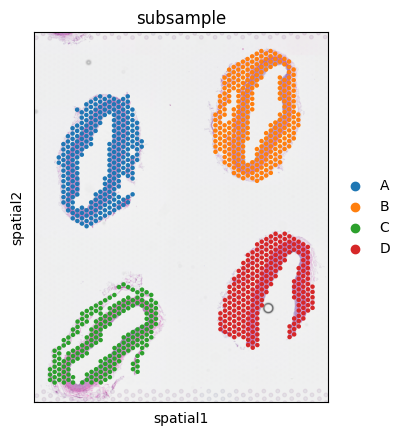

In [13]:
#Example of the subsample assignment
slide = select_slide(adata_vis, 'FW106018')
sc.pl.spatial(slide, cmap='viridis',
                  # show first 8 cell types
                  color=['subsample'],
                  ncols=3, size=1.3,
                  img_key='hires',
                 )


## Function to define the interpolation from lumina to periphery

In [14]:
def calculate_interpolation_values(anndata, num_sectors=90, x_offset=None, y_offset=None, subsample_label="A"):
    """
    Calculate interpolation values for each spot in 12 sectors relative to the center.

    Parameters:
        anndata (anndata.AnnData): Anndata object containing spatial data.
        num_sectors (int): Number of sectors (default is 90).
        x_offset (float or None): Value to add to the x-coordinate of the center. If None, no offset is applied.
        y_offset (float or None): Value to add to the y-coordinate of the center. If None, no offset is applied.
        subsample_label (str): The label of the subsample to consider when calculating the interpolation values.

    Returns:
        anndata.AnnData: Anndata object with interpolation values added to a new column 'lumina_to_periphery' in anndata.obs.
    """
    # Filter spots based on the subsample_label
    anndata_subset = anndata[anndata.obs["subsample"] == subsample_label].copy()

    # Calculate the center of the spatial coordinates for the subset
    spatial_coordinates = anndata_subset.obsm["spatial"]

    # Apply the offset to the center if provided
    if x_offset is not None:
        x_center = np.mean(spatial_coordinates[:, 0]) + x_offset
    else:
        x_center = np.mean(spatial_coordinates[:, 0])

    if y_offset is not None:
        y_center = np.mean(spatial_coordinates[:, 1]) + y_offset
    else:
        y_center = np.mean(spatial_coordinates[:, 1])

    # Calculate the distances of each spot to the center
    distances = np.sqrt((spatial_coordinates[:, 0] - x_center) ** 2 + (spatial_coordinates[:, 1] - y_center) ** 2)

    # Calculate the angle (θ) for each spot relative to the center
    relative_x = spatial_coordinates[:, 0] - x_center
    relative_y = spatial_coordinates[:, 1] - y_center
    angles_radians = np.arctan2(relative_y, relative_x)

    # Convert angles to degrees and shift the range from [-180, 180] to [0, 360]
    angles_degrees = np.degrees(angles_radians)
    angles_degrees[angles_degrees < 0] += 360

    # Create an array to store the interpolation values for each spot
    interpolation_values = np.zeros(len(spatial_coordinates))

    sector_size = 360 / num_sectors

    for i in range(num_sectors):
        sector_start = i * sector_size
        sector_end = (i + 1) * sector_size

        # Find the indices of spots within the current sector
        sector_indices = np.where((angles_degrees >= sector_start) & (angles_degrees < sector_end))[0]

        if len(sector_indices) > 0:
            # Find the index of the closest spot within the current sector
            idx_closest = sector_indices[np.argmin(distances[sector_indices])]

            # Find the index of the farthest spot within the current sector
            idx_farthest = sector_indices[np.argmax(distances[sector_indices])]

            # Calculate the distances to the closest and farthest spots
            dist_closest = distances[idx_closest]
            dist_farthest = distances[idx_farthest]

            # Calculate the interpolation values for the current sector
            values = (distances[sector_indices] - dist_closest) / (dist_farthest - dist_closest)

            # Assign the interpolation values to the corresponding spots
            interpolation_values[sector_indices] = values

    # Create a copy of the original Anndata object to avoid modifying the input data
    anndata_copy = anndata.copy()

    # Add the interpolation_values as a new column to the subset in anndata_copy.obs
    anndata_copy.obs.loc[anndata_subset.obs.index, 'lumina_to_periphery'] = interpolation_values

    return anndata_copy


In [15]:
slides_info = [
    {'slide': 'FW106005_v2', 'x_offset': -2100, 'y_offset': 500, 'subsample_label': 'A'},
    {'slide': 'FW106006', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'A'},
    {'slide': 'FW106006', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'D'},
    {'slide': 'FW106008', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'A'},
    {'slide': 'FW106008', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'B'},
    {'slide': 'FW106010', 'x_offset': 500, 'y_offset': -1000, 'subsample_label': 'A'},
    {'slide': 'FW106010', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'C'},
    {'slide': 'FW106010', 'x_offset': 500, 'y_offset': -1000, 'subsample_label': 'D'},
    {'slide': 'FW106012', 'x_offset': -3000, 'y_offset': 0, 'subsample_label': 'A'},
    {'slide': 'FW106012', 'x_offset': -4000, 'y_offset': 0, 'subsample_label': 'C'},
    {'slide': 'FW106012', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'D'},
    {'slide': 'FW106014', 'x_offset': 500, 'y_offset': 1000, 'subsample_label': 'A'},
    {'slide': 'FW106016', 'x_offset': 500, 'y_offset': 500, 'subsample_label': 'A'},
    {'slide': 'FW106016', 'x_offset': 500, 'y_offset': 0, 'subsample_label': 'B'},
    {'slide': 'FW106018', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'A'},
    {'slide': 'FW106018', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'B'},
    {'slide': 'FW106018', 'x_offset': 0, 'y_offset': 0, 'subsample_label': 'C'},
    {'slide': 'FW106018', 'x_offset': 1000, 'y_offset': 2000, 'subsample_label': 'D'},
    {'slide': 'FW106022', 'x_offset': 2000, 'y_offset': -2000, 'subsample_label': 'A'}
]

# Loop through the slides_info list and perform the calculations
for slide_info in slides_info:
    slide = select_slide(adata_vis, slide_info['slide'])
    slide = calculate_interpolation_values(slide, x_offset=slide_info['x_offset'], y_offset=slide_info['y_offset'],
                                           subsample_label=slide_info['subsample_label'])

    # Update the interpolation_values in the adata_vis.obs DataFrame for the corresponding slide
    adata_vis.obs.loc[slide.obs.index, "lumina_to_periphery"] = slide.obs['lumina_to_periphery']


/var/folders/lx/sv1ghxqx5_q6s4byc0rl91p00000gn/T/ipykernel_2858/770703096.py:68: RuntimeWarning: invalid value encountered in true_divide
  values = (distances[sector_indices] - dist_closest) / (dist_farthest - dist_closest)


/var/folders/lx/sv1ghxqx5_q6s4byc0rl91p00000gn/T/ipykernel_2858/770703096.py:68: RuntimeWarning: invalid value encountered in true_divide
  values = (distances[sector_indices] - dist_closest) / (dist_farthest - dist_closest)


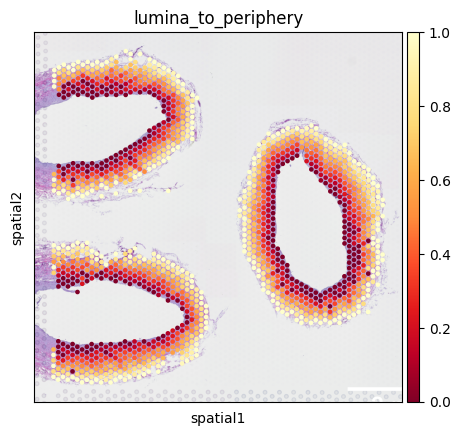

In [16]:
slide = select_slide(adata_vis, 'FW106012')
slide = calculate_interpolation_values(slide, num_sectors=90, x_offset=1000, y_offset=2000, subsample_label="D")
sc.pl.spatial(slide, cmap='YlOrRd_r',
                  # show first 8 cell types
                  color=['lumina_to_periphery'],
                  ncols=3, size=1.3,
                  img_key='hires',
                 )

In [17]:
Sample_to_Disease = dict(
    FW104302="Fibroatheroma",
    FW104306="Fibroatheroma",
    FW104860="Atheroma",
    FW106005_v2="Atheroma",
    FW106006="Intermediate \n lesion",
    FW106008="Intermediate \n lesion",
    FW106010="Control",
    FW106012="Control",
    FW106014="Atheroma",
    FW106016="Atheroma",
    FW106018="Control",
    FW106022="Atheroma")
adata_vis.obs['Disease'] = (
    adata_vis.obs['sample'].map(Sample_to_Disease)
)